In [1]:
import requests
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('bmh')

## Source
https://opentender.eu/data/files/data-no-csv.zip <br>

In [2]:
url = "https://opentender.eu/data/files/data-no-csv.zip"
filename = "tender-data-csv.zip"
folder = "tender-data-csv"
r = requests.get(url)
if r.status_code == 200:
    print("Successfull HTTP-response!\n")
    
    # Get zipped content
    with open(filename, "wb") as f:
        f.write(r.content)
    
    # Unzip conent into folder
    with zipfile.ZipFile(filename, "r") as zip_obj:
        data_file_names = zip_obj.extractall(folder)
        print(f"A folder '{folder}' has been made and populated with:")
        for filename in zip_obj.namelist():
            print(filename)
else:
    print("Not able to contact server.")


Successfull HTTP-response!

A folder 'tender-data-csv' has been made and populated with:
data-no-2009.csv
data-no-2010.csv
data-no-2011.csv
data-no-2012.csv
data-no-2013.csv
data-no-2014.csv
data-no-2015.csv
data-no-2016.csv
data-no-2017.csv
data-no-2018.csv
data-no-2019.csv
data-no-2020.csv
data-no-year-unavailable.csv


## Read and explore data

In [3]:
data_sources = Path(folder).glob("*.csv")
dfs = {}
for src_path in data_sources:
    suffix = str(src_path).split("-")[-1][:-4]
    dfs[suffix] = pd.read_csv(src_path,
                               sep=";",
                               encoding="utf8",
                               low_memory=False)
df_noyear = dfs["unavailable"]
dfs["0000"] = dfs["unavailable"]
del dfs["unavailable"]

### Examine null values
All datasets consists of over 50 % null values.
I.e. it is more empty than not.

In [4]:
years         = []
null_percents = []
sizes         = []
null_values     = []
for key, df in dfs.items():
    rows, cols = df.shape
    elements = df.size
    null_vals = df.isna().sum().sum()
    null_percent = null_vals / elements * 100
    years.append(int(key))
    null_percents.append(null_percent)
    sizes.append(elements)
    null_values.append(null_vals)
#    print(f"{key}: {null_percent:3.0f}")

print("Share of null values:")
for year, null_percent, size in sorted(zip(years, null_percents, sizes)):
        print(f"{year:4.0f}: {null_percent:3.0f} % of {size:,} elements")

print(f"\nAll datasets have between {min(null_percents):2.0f} %"
      + f" and {max(null_percents):2.0f} % null values.")

print("\nDataset with no year:")
print(f"{df_noyear.isna().sum().sum()/df_noyear.size*100:2.0f} % null"
     + f" values of {df_noyear.size:,} values. "
     + f"This dataset makes up {df_noyear.size/sum(sizes)*100:2.0f} % of all data.")

Share of null values:
   0:  68 % of 9,487,400 elements
2009:  59 % of 2,943,200 elements
2010:  61 % of 2,438,020 elements
2011:  59 % of 2,611,050 elements
2012:  59 % of 2,780,830 elements
2013:  59 % of 2,712,840 elements
2014:  56 % of 2,480,920 elements
2015:  56 % of 2,537,470 elements
2016:  56 % of 2,474,680 elements
2017:  54 % of 2,182,440 elements
2018:  58 % of 1,661,140 elements
2019:  57 % of 2,014,740 elements
2020:  59 % of 1,233,050 elements

All datasets have between 54 % and 68 % null values.

Dataset with no year:
68 % null values of 9,487,400 values. This dataset makes up 25 % of all data.


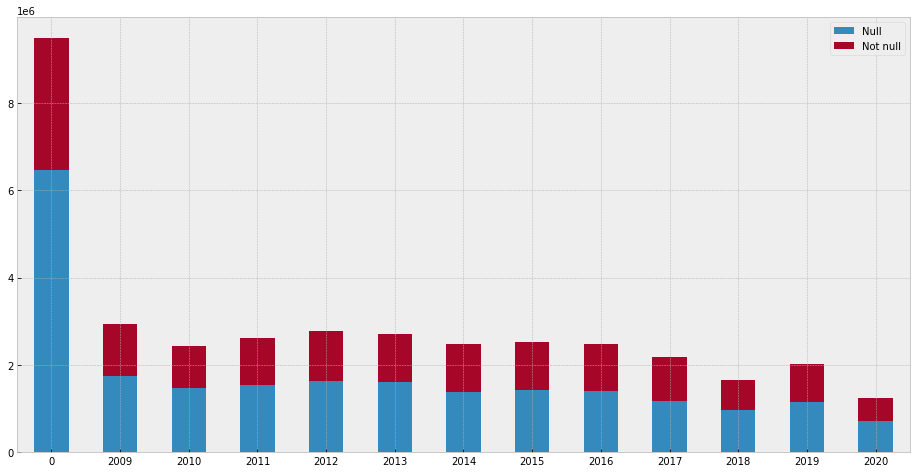

In [5]:
df_eda = pd.DataFrame({
    "Null": null_values,
    "Not null": sizes
}, index=years)
df_eda["Not null"] -= df_eda["Null"]
df_eda.sort_index(inplace=True)
df_eda.plot(kind="bar",
            figsize=(16,8),
            stacked=True,
            rot=0)
plt.show()

## Investigate buyers main activities

### Check that all columns are equal before concatinating

In [6]:
columns = dfs["2009"].columns
is_comparable_list = []
print("Is comparable to 2009:")
for year, df in dfs.items():
    is_comparable = (df.columns==columns).all()
    is_comparable_list.append(is_comparable)
    print(year, ": ", is_comparable)

del dfs["0000"]  # Ignoring this data for now
if is_comparable.all():
    df_global = pd.concat(dfs.values())
    print("\nSuccessfull concatination!")

Is comparable to 2009:
2010 :  True
2011 :  True
2013 :  True
2012 :  True
2016 :  True
2017 :  True
2015 :  True
2014 :  True
2019 :  True
2018 :  True
2020 :  True
2009 :  True
0000 :  True

Successfull concatination!


### Examine all columns

In [7]:
print(df_global.info(verbose=True,
                     null_counts=True,
                     memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215926 entries, 0 to 22639
Data columns (total 130 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   tender_row_nr                                                   215926 non-null  int64  
 1   tender_id                                                       215926 non-null  object 
 2   tender_country                                                  215926 non-null  object 
 3   tender_title                                                    200234 non-null  object 
 4   tender_size                                                     41419 non-null   object 
 5   tender_supplyType                                               206668 non-null  object 
 6   tender_procedureType                                            177726 non-null  object 
 7   tender_nationalProcedureType          

### Find all unique buyer main activities

In [8]:
buyer_main_acts = df_global.buyer_mainActivities.str.lower()
buyer_main_acts[buyer_main_acts.isna()] = "unassigned"

unique_acts = set()
for acts in buyer_main_acts.str.split(","):
    for act in acts:
        unique_acts.add(act)

print(len(unique_acts), "activities:")
for act in unique_acts:
    print(act)

21 activities:
defence
public_order_and_safety
railway
port
gas_and_oil_extraction
unassigned
postal
general_public_services
education
recreation_culture_and_religion
water
environment
urban_transport
economic_and_financial_affairs
social_protection
airport
electricity
health
housing_and_community_amenities
gas_and_heat_production
other


### Create new DataFrame to investigate activities by year

In [9]:
activity_dict = {"year": df_global.tender_year}
for act in unique_acts:
    activity_dict[act] = buyer_main_acts.str.contains(act)

df_activity = pd.DataFrame(activity_dict)
print(df_activity.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215926 entries, 0 to 22639
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   year                             215926 non-null  int64
 1   defence                          215926 non-null  bool 
 2   public_order_and_safety          215926 non-null  bool 
 3   railway                          215926 non-null  bool 
 4   port                             215926 non-null  bool 
 5   gas_and_oil_extraction           215926 non-null  bool 
 6   unassigned                       215926 non-null  bool 
 7   postal                           215926 non-null  bool 
 8   general_public_services          215926 non-null  bool 
 9   education                        215926 non-null  bool 
 10  recreation_culture_and_religion  215926 non-null  bool 
 11  water                            215926 non-null  bool 
 12  environment                    

### Activities growth in activities from 2009 to 2019
The posts "Water" and "Public order and safety" has grown the most. <br>
It is the only activities that has more than doubled.

In [10]:
df_yearly_act = df_activity.groupby("year").sum()
df_yearly_act_stds = df_activity.groupby("year").sum().std()
rel_std = df_yearly_act_stds / df_activity.groupby("year").sum().mean()
abs_diff_19_09 = df_yearly_act.loc[2019, :] - df_yearly_act.loc[2009, :]
rel_diff_19_09 = abs_diff_19_09 / df_yearly_act.loc[2009, :]
df_19_09_comp = pd.DataFrame({
    "rel_diff": rel_diff_19_09.round(2).sort_values(ascending=False),
    "std_rel": rel_std
})

df_19_09_comp_sorted = df_19_09_comp.sort_values("rel_diff", ascending=False)
print("Relative change from 2009 to 2019:")
print(df_19_09_comp_sorted.round(2))

Relative change from 2009 to 2019:
                                 rel_diff  std_rel
water                                2.38     0.43
public_order_and_safety              2.12     0.43
social_protection                    1.80     0.44
gas_and_heat_production              0.89     0.46
recreation_culture_and_religion      0.86     0.32
railway                              0.76     0.50
environment                          0.55     0.32
health                               0.52     0.30
education                            0.37     0.26
defence                             -0.01     0.31
economic_and_financial_affairs      -0.02     0.26
housing_and_community_amenities     -0.10     0.19
general_public_services             -0.14     0.16
other                               -0.25     0.20
electricity                         -0.29     0.31
urban_transport                     -0.65     0.57
port                                -0.72     0.48
unassigned                          -0.73     0

#### A closer look at the 5 posts with the most growth from 2009 to 2019
The growth is significantly bigger than the standard deviation for all years.

In [11]:
growth_cols = df_19_09_comp.sort_values("rel_diff", ascending=False)[:5].index
df_yearly_act[growth_cols].describe().round(1)

,water,public_order_and_safety,social_protection,gas_and_heat_production,recreation_culture_and_religion
count,12.0,12.0,12.0,12.0,12.0
mean,443.9,974.8,1046.0,59.8,1236.5
std,191.2,416.2,462.8,27.4,396.1
min,126.0,393.0,477.0,19.0,718.0
25%,292.8,714.2,653.8,45.5,836.8
50%,467.5,969.0,1006.0,52.5,1228.0
75%,566.2,1144.0,1344.5,72.8,1579.8
max,713.0,1850.0,1857.0,117.0,1760.0


### Visualizing yearly activities
With table under, in case colors are hard to see.<br>
The posts "Other" and "General public services" has the biggest change in activity over all.

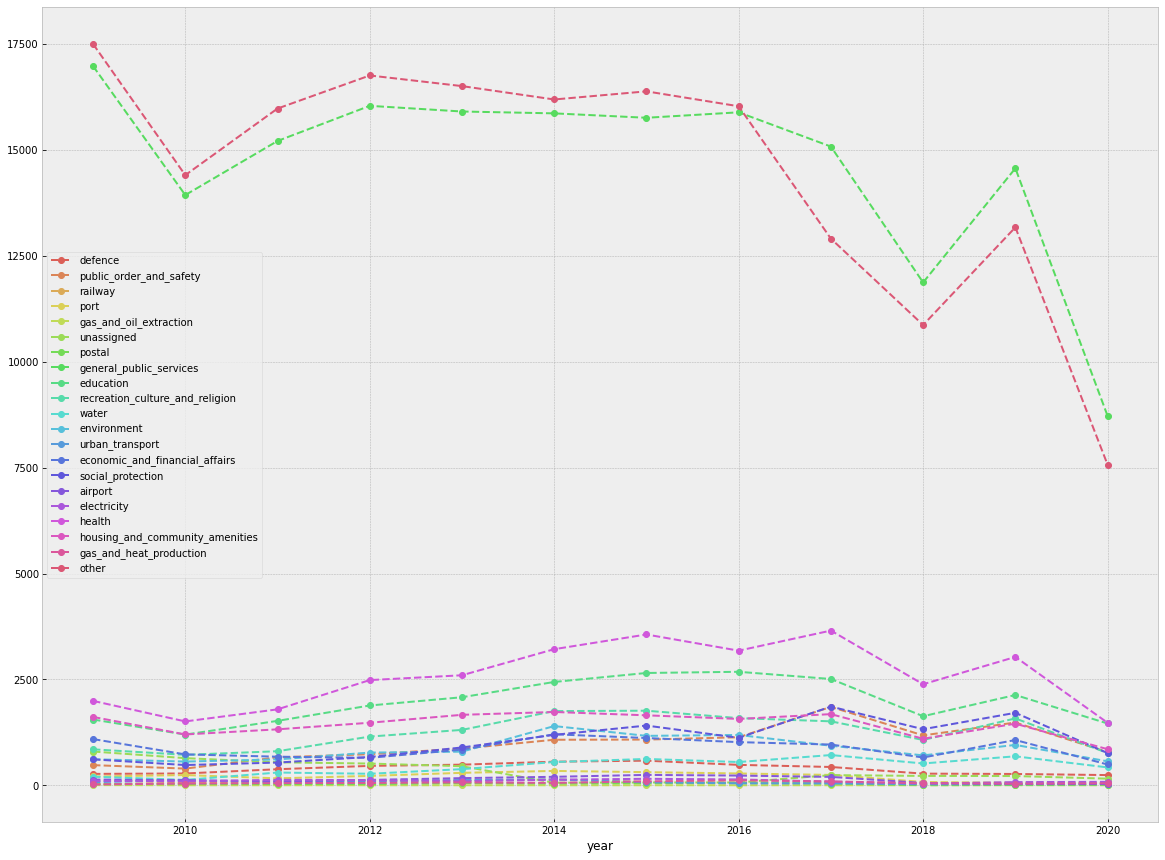

In [12]:
color_palette = sns.color_palette("hls", len(df_yearly_act.columns))
df_yearly_act.plot(figsize=(20,15), style="--o", color=color_palette)
plt.show()

In [13]:
df_yearly_act

,defence,public_order_and_safety,railway,port,gas_and_oil_extraction,unassigned,postal,general_public_services,education,recreation_culture_and_religion,water,environment,urban_transport,economic_and_financial_affairs,social_protection,airport,electricity,health,housing_and_community_amenities,gas_and_heat_production,other
year,,,,,,,,,,,,,,,,,,,,,
2009,268,475,21,207,3,796,26,16983,1552,848,202,614,72,1090,611,135,104,1992,1613,19,17505
2010,278,393,58,240,0,640,28,13937,1196,718,126,559,120,728,477,118,92,1507,1199,41,14407
2011,378,658,86,163,0,542,30,15214,1520,803,300,610,66,674,535,92,128,1792,1320,50,15980
2012,457,733,106,220,0,512,27,16044,1883,1149,271,771,91,647,668,126,121,2483,1476,55,16761
2013,486,864,107,293,0,449,54,15910,2078,1307,380,793,124,841,892,168,94,2597,1663,67,16510
2014,556,1074,136,338,0,59,40,15866,2439,1751,548,1397,136,1203,1190,199,131,3213,1730,55,16194
2015,580,1078,79,309,0,65,50,15762,2651,1760,621,1166,69,1115,1409,244,152,3560,1651,92,16386
2016,481,1133,62,278,0,65,50,15891,2679,1585,548,1187,46,1018,1120,228,137,3178,1566,117,16034
2017,431,1850,76,244,0,239,40,15082,2509,1509,713,933,45,961,1857,197,86,3652,1679,90,12907


### Correlating yearly changes
Some interesting strong correlations (>0.9:<br>
"Social protection" with "Water", and and "Public order and safety".<br>
"Environment" with "Education", and with "Recreation, culture and religion".<br>
"Health" with "Recreation, culture and religion".

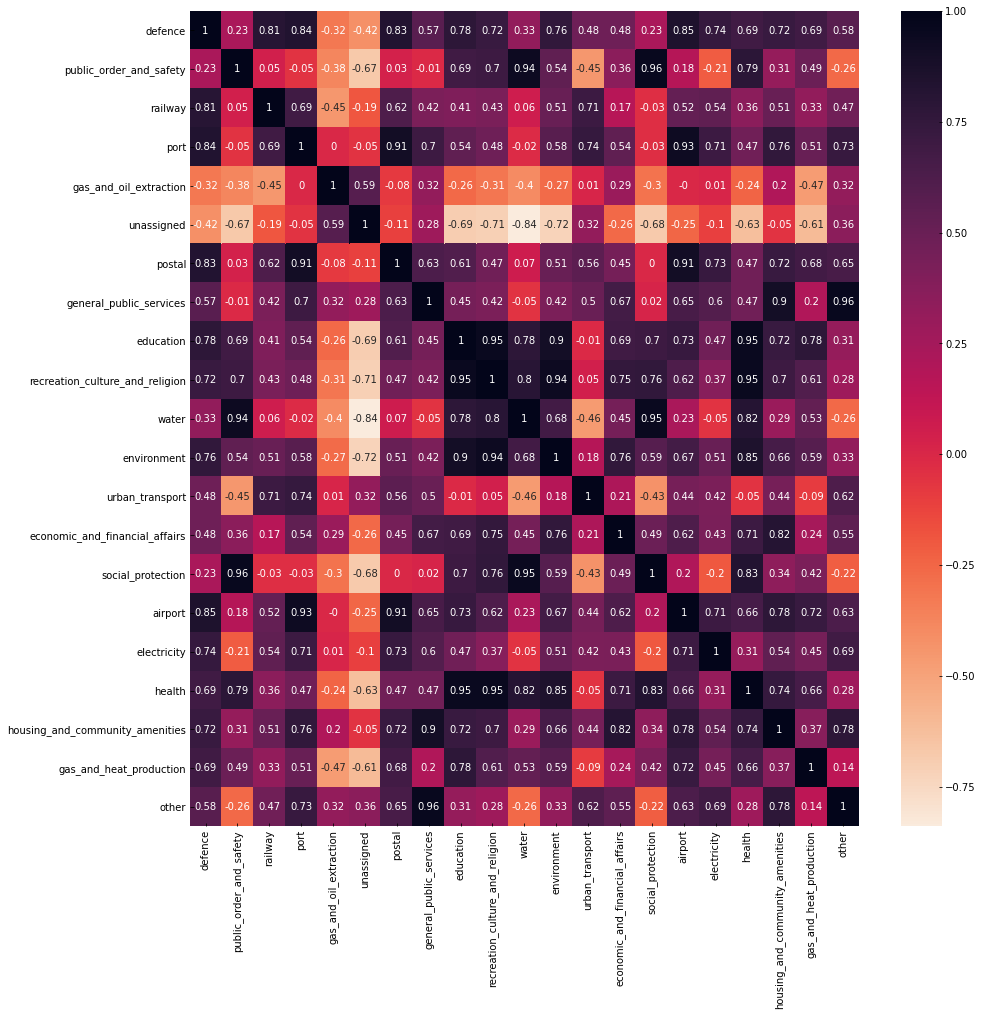

In [14]:
act_corr = df_activity.groupby("year").sum().corr().round(2)
plt.figure(figsize=(15,15))
ax = sns.heatmap(act_corr, annot=True, cmap="rocket_r")